## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import tensorflow.keras as keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [5, 10]

In [7]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_v2 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

50000/50000 [==============================] - 3s 57us/sample - loss: 1.3333 - accuracy: 0.5350 - val_loss: 1.5137 - val_accuracy: 0.4642
Epoch 11/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.3085 - accuracy: 0.5437 - val_loss: 1.5078 - val_accuracy: 0.4659
Epoch 12/25
50000/50000 [==============================] - 4s 72us/sample - loss: 1.2849 - accuracy: 0.5533 - val_loss: 1.4886 - val_accuracy: 0.4776
Epoch 13/25
50000/50000 [==============================] - 4s 72us/sample - loss: 1.2632 - accuracy: 0.5617 - val_loss: 1.4904 - val_accuracy: 0.4734
Epoch 14/25
50000/50000 [==============================] - 3s 69us/sample - loss: 1.2408 - accuracy: 0.5698 - val_loss: 1.4770 - val_accuracy: 0.4816
Epoch 15/25
50000/50000 [==============================] - 3s 65us/sample - loss: 1.2188 - accuracy: 0.5770 - val_loss: 1.4667 - val_accuracy: 0.4843
Epoch 16/25
50000/50000 [==============================] - 3s 59us/sample - loss: 1.1992 - accuracy: 0.5842 - va

Epoch 1/25
50000/50000 [==============================] - 3s 67us/sample - loss: 2.2403 - accuracy: 0.2617 - val_loss: 2.1635 - val_accuracy: 0.1855
Epoch 2/25
50000/50000 [==============================] - 3s 58us/sample - loss: 1.7626 - accuracy: 0.3833 - val_loss: 1.9843 - val_accuracy: 0.2872
Epoch 3/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.6337 - accuracy: 0.4251 - val_loss: 1.8375 - val_accuracy: 0.3593
Epoch 4/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.5612 - accuracy: 0.4512 - val_loss: 1.7071 - val_accuracy: 0.4092
Epoch 5/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.5078 - accuracy: 0.4718 - val_loss: 1.6389 - val_accuracy: 0.4248
Epoch 6/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.4643 - accuracy: 0.4880 - val_loss: 1.5906 - val_accuracy: 0.4447
Epoch 7/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.4277 - accuracy: 0.5017

50000/50000 [==============================] - 4s 75us/sample - loss: 0.5114 - accuracy: 0.8385 - val_loss: 1.5940 - val_accuracy: 0.5005
Epoch 20/25
50000/50000 [==============================] - 3s 70us/sample - loss: 0.4858 - accuracy: 0.8458 - val_loss: 1.6238 - val_accuracy: 0.5041
Epoch 21/25
50000/50000 [==============================] - 3s 68us/sample - loss: 0.4568 - accuracy: 0.8564 - val_loss: 1.6809 - val_accuracy: 0.4903
Epoch 22/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.4292 - accuracy: 0.8674
Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
50000/50000 [==============================] - 4s 75us/sample - loss: 0.4302 - accuracy: 0.8669 - val_loss: 1.7458 - val_accuracy: 0.4878
Epoch 23/25
50000/50000 [==============================] - 4s 80us/sample - loss: 0.3604 - accuracy: 0.8993 - val_loss: 1.6217 - val_accuracy: 0.5274
Epoch 24/25
50000/50000 [==============================] - 5s 91us/sample - loss: 0.3289 - ac

50000/50000 [==============================] - 4s 77us/sample - loss: 1.7975 - accuracy: 0.3769 - val_loss: 2.2628 - val_accuracy: 0.1689
Epoch 2/25
50000/50000 [==============================] - 3s 66us/sample - loss: 1.4864 - accuracy: 0.4764 - val_loss: 1.8348 - val_accuracy: 0.3551
Epoch 3/25
50000/50000 [==============================] - 3s 63us/sample - loss: 1.3856 - accuracy: 0.5127 - val_loss: 1.6831 - val_accuracy: 0.4134
Epoch 4/25
50000/50000 [==============================] - 3s 61us/sample - loss: 1.3131 - accuracy: 0.5401 - val_loss: 1.5732 - val_accuracy: 0.4479
Epoch 5/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.2579 - accuracy: 0.5617 - val_loss: 1.5019 - val_accuracy: 0.4773
Epoch 6/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.2052 - accuracy: 0.5805 - val_loss: 1.5416 - val_accuracy: 0.4521
Epoch 7/25
50000/50000 [==============================] - 3s 64us/sample - loss: 1.1635 - accuracy: 0.5955 - val_loss

50000/50000 [==============================] - 3s 67us/sample - loss: 1.0910 - accuracy: 0.6290 - val_loss: 1.4588 - val_accuracy: 0.4934
Epoch 20/25
50000/50000 [==============================] - 3s 70us/sample - loss: 1.0777 - accuracy: 0.6343 - val_loss: 1.4693 - val_accuracy: 0.4909
Epoch 21/25
50000/50000 [==============================] - 3s 67us/sample - loss: 1.0639 - accuracy: 0.6383 - val_loss: 1.4307 - val_accuracy: 0.4998
Epoch 22/25
50000/50000 [==============================] - 3s 65us/sample - loss: 1.0492 - accuracy: 0.6440 - val_loss: 1.4407 - val_accuracy: 0.4981
Epoch 23/25
50000/50000 [==============================] - 3s 68us/sample - loss: 1.0359 - accuracy: 0.6495 - val_loss: 1.4374 - val_accuracy: 0.4992
Epoch 24/25
50000/50000 [==============================] - 4s 71us/sample - loss: 1.0222 - accuracy: 0.6549 - val_loss: 1.4389 - val_accuracy: 0.5006
Epoch 25/25
50000/50000 [==============================] - 3s 66us/sample - loss: 1.0098 - accuracy: 0.6600 - va

50000/50000 [==============================] - 4s 73us/sample - loss: 1.8618 - accuracy: 0.3630 - val_loss: 2.0737 - val_accuracy: 0.2658
Epoch 2/25
50000/50000 [==============================] - 3s 67us/sample - loss: 1.5477 - accuracy: 0.4562 - val_loss: 1.8928 - val_accuracy: 0.3180
Epoch 3/25
50000/50000 [==============================] - 4s 75us/sample - loss: 1.4417 - accuracy: 0.4908 - val_loss: 1.8059 - val_accuracy: 0.3408
Epoch 4/25
50000/50000 [==============================] - 4s 72us/sample - loss: 1.3630 - accuracy: 0.5184 - val_loss: 1.6904 - val_accuracy: 0.3937
Epoch 5/25
50000/50000 [==============================] - 3s 70us/sample - loss: 1.2998 - accuracy: 0.5431 - val_loss: 1.7062 - val_accuracy: 0.3906
Epoch 6/25
50000/50000 [==============================] - 4s 74us/sample - loss: 1.2459 - accuracy: 0.5625 - val_loss: 1.8131 - val_accuracy: 0.3614
Epoch 7/25
50000/50000 [==============================] - 4s 76us/sample - loss: 1.2040 - accuracy: 0.5794 - val_loss

Epoch 19/25
50000/50000 [==============================] - 4s 70us/sample - loss: 0.9089 - accuracy: 0.7001 - val_loss: 1.3918 - val_accuracy: 0.5090
Epoch 20/25
50000/50000 [==============================] - 4s 70us/sample - loss: 0.8926 - accuracy: 0.7063 - val_loss: 1.3978 - val_accuracy: 0.5141
Epoch 21/25
50000/50000 [==============================] - 4s 70us/sample - loss: 0.8826 - accuracy: 0.7105 - val_loss: 1.4094 - val_accuracy: 0.5108
Epoch 22/25
50000/50000 [==============================] - 4s 70us/sample - loss: 0.8737 - accuracy: 0.7144 - val_loss: 1.4075 - val_accuracy: 0.5106
Epoch 23/25
50000/50000 [==============================] - 3s 70us/sample - loss: 0.8654 - accuracy: 0.7166 - val_loss: 1.4076 - val_accuracy: 0.5138
Epoch 24/25
49152/50000 [============================>.] - ETA: 0s - loss: 0.8564 - accuracy: 0.7205
Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.1250000534346328e-05.
50000/50000 [==============================] - 4s 70us/sample - loss

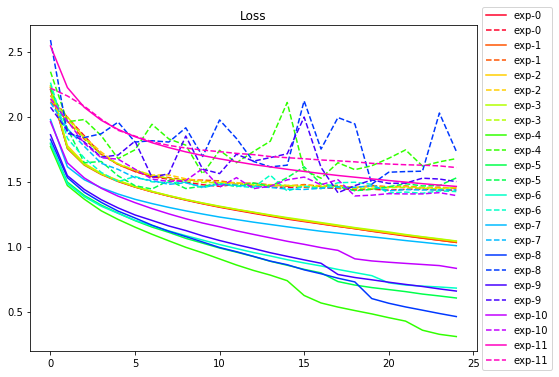

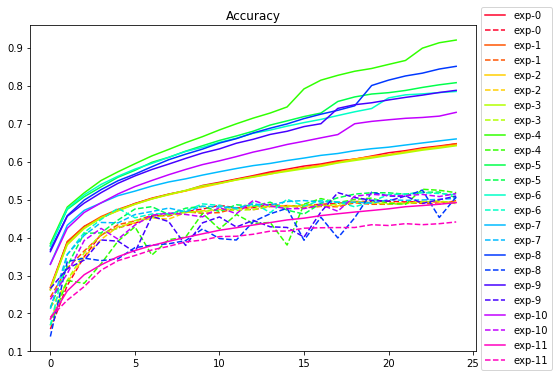

In [8]:
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()